# Desafio 2 - Análisando dados do INEP
---

## Grupo
- Jérémie Dron
- Gleisson Bispo
- Lorena Corina
- Marcos Azevedo
- Rodrigo Pasqualucci

## Dataset
- Microdados Educação Superior 2017 - INEP

## Desafios:
- Tabelas com número de universidades públicas e privadas por estado e número de alunos por universidade 
- Pergunta-se: é verdade que existe menos mulheres nos cursos de exatas? Explique com os dados.
- Quantos cursos novos abrem por ano? 
- Se usarmos a taxa de concluientes de um curso como variável de dificuldade dos cursos, eles tem ficado mais faceis ou mais duros ao longo do tempo? Quais as dificuldades para uma afirmação dessas?
- Rode uma regressão multipla que explique o abandono dos cursos, será que professores mais/menos preparados influência nessas taxas?
- Quais os cursos com maior crescimento de matriculas por região? E quais os com maior queda? Como você explicaria isso.
- Construa uma variável "Signo" dos estudantes e explique porque ela é correlacionada com a variável "probabilidade de formação" (construir)


### Lendo Bibliotecas

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns


## 1) Tabelas com número de universidades públicas e privadas por estado e número de alunos por universidade

In [2]:
#Lendo DF de instituições no Brasil
df_ies = pd.read_csv(r'microdados_educacao_superior_2017/DADOS/DM_IES.csv', delimiter='|', encoding='latin1')

#Dropando colunas que não serão utilizadas
df_ies.drop(['NU_ANO_CENSO',
             'SG_IES',
             'CO_MANTENEDORA',
             'NO_MANTENEDORA',
             'CO_REGIAO',
             'CO_MUNICIPIO',
             'IN_CAPITAL',
             'QT_TEC_TOTAL',
             'QT_TEC_FUNDAMENTAL_INCOMP_FEM',
             'QT_TEC_FUNDAMENTAL_INCOMP_MASC',
             'QT_TEC_FUNDAMENTAL_COMP_FEM',
             'QT_TEC_FUNDAMENTAL_COMP_MASC',
             'QT_TEC_MEDIO_FEM',
             'QT_TEC_MEDIO_MASC',
             'QT_TEC_SUPERIOR_FEM',
             'QT_TEC_SUPERIOR_MASC',
             'QT_TEC_ESPECIALIZACAO_FEM',
             'QT_TEC_ESPECIALIZACAO_MASC',
             'QT_TEC_MESTRADO_FEM',
             'QT_TEC_MESTRADO_MASC',
             'QT_TEC_DOUTORADO_FEM',
             'QT_TEC_DOUTORADO_MASC',
             'IN_ACESSO_PORTAL_CAPES',
             'IN_ACESSO_OUTRAS_BASES',
             'IN_REPOSITORIO_INSTITUCIONAL',
             'IN_BUSCA_INTEGRADA',
             'IN_SERVICO_INTERNET',
             'IN_PARTICIPA_REDE_SOCIAL',
             'IN_CATALOGO_ONLINE',
             'QT_PERIODICO_ELETRONICO',
             'QT_LIVRO_ELETRONICO',
             'TP_REFERENTE',
             'VL_RECEITA_PROPRIA',
             'VL_RECEITA_TRANSFERENCIA',
             'VL_RECEITA_OUTRA',
             'VL_DESPESA_PESSOAL_DOCENTE',
             'VL_DESPESA_PESSOAL_TECNICO',
             'VL_DESPESA_PESSOAL_ENCARGO',
             'VL_DESPESA_CUSTEIO',
             'VL_DESPESA_INVESTIMENTO',
             'VL_DESPESA_PESQUISA',
             'VL_DESPESA_OUTRA'], axis=1, inplace=True)

df_ies.head()

,CO_IES,NO_IES,TP_CATEGORIA_ADMINISTRATIVA,TP_ORGANIZACAO_ACADEMICA,CO_UF
0,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,1,51
1,2,UNIVERSIDADE DE BRASÍLIA,1,1,53
2,3,UNIVERSIDADE FEDERAL DE SERGIPE,1,1,28
3,4,UNIVERSIDADE FEDERAL DO AMAZONAS,1,1,13
4,6,UNIVERSIDADE FEDERAL DE OURO PRETO,1,1,31


In [3]:
#Lendo Tabela de codigos IBGE para UF
df_cod_uf = pd.read_html('https://www.oobj.com.br/bc/article/quais-os-c%C3%B3digos-de-cada-uf-no-brasil-465.html')
df_cod_uf[0].columns = ['CO_UF', 'UF_NAME', 'UF']
df_cod_uf[0]['UF_NAME'].replace('Rio Grande do Sul (*)', 'Rio Grande do Sul', inplace=True)
df_cod_uf[0].head()

,CO_UF,UF_NAME,UF
0,11,Rondônia,RO
1,12,Acre,AC
2,13,Amazonas,AM
3,14,Roraima,RR
4,15,Pará,PA


In [4]:
#Atribuindo nome aos estados
df_ies = pd.merge(df_ies, df_cod_uf[0][['CO_UF', 'UF_NAME']], on='CO_UF', how='inner')
df_ies.head()

,CO_IES,NO_IES,TP_CATEGORIA_ADMINISTRATIVA,TP_ORGANIZACAO_ACADEMICA,CO_UF,UF_NAME
0,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,1,51,Mato Grosso
1,1936,FACULDADE LA SALLE,5,3,51,Mato Grosso
2,719,UNIVERSIDADE DO ESTADO DE MATO GROSSO,2,1,51,Mato Grosso
3,3776,INSTITUTO DE ENSINO SUPERIOR DE MATO GROSSO,5,3,51,Mato Grosso
4,780,UNIVERSIDADE DE CUIABÁ,4,1,51,Mato Grosso


In [5]:
#Lendo as informações dos estados do mapa do Brasil para plotagem posteriormente
df_map = gpd.read_file(r'data/br_unidades_da_federacao/BRUFE250GC_SIR.shx')
cod = []
for x in range(len(df_map)):
    cod.append(int(df_map['CD_GEOCUF'][x]))
df_map['CO_UF'] = cod

---

### Universidades Publicas

In [6]:
#Criando DF Universidades (Cod.1) Publicas (Cod. 1, 2 e 3) por Estado
pub = [1, 2, 3]
df_uni_pub_qt = df_ies[['CO_IES', 'UF_NAME']][(df_ies['TP_CATEGORIA_ADMINISTRATIVA'].isin(pub)) & 
                                  (df_ies['TP_ORGANIZACAO_ACADEMICA']==1)].groupby('UF_NAME').count().reset_index()

df_uni_pub_qt.columns = ['NOME_UF', 'QNT_PUBLICAS']

df_uni_pub_qt

,NOME_UF,QNT_PUBLICAS
0,Acre,1
1,Alagoas,3
2,Amapá,2
3,Amazonas,2
4,Bahia,8
5,Ceará,6
6,Distrito Federal,1
7,Espírito Santo,1
8,Goiás,3
9,Maranhão,2


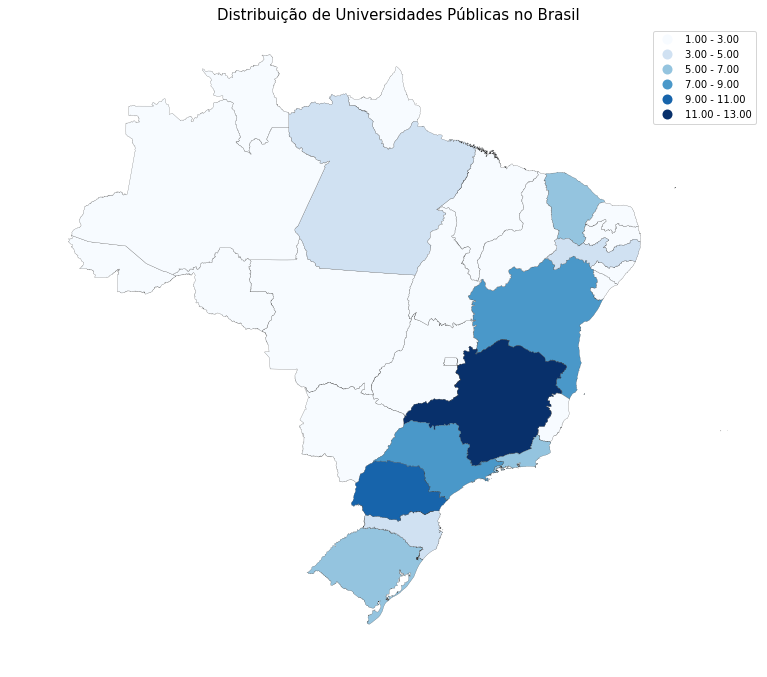

In [7]:
#Criando DF Universidades (Cod.1) Publicas (Cod. 1, 2 e 3) por Estado e cordenadas do mapa
pub = [1, 2, 3]
df_uni_pub_map = df_ies[['CO_IES', 'CO_UF']][(df_ies['TP_CATEGORIA_ADMINISTRATIVA'].isin(pub)) & 
                              (df_ies['TP_ORGANIZACAO_ACADEMICA']==1)].groupby('CO_UF').count().reset_index()
df_uni_pub_map.columns = ['CO_UF', 'QNT_PUBLICAS']

df_uni_pub_map = pd.merge(df_map[['CO_UF', 'geometry']], df_uni_pub_map, on='CO_UF', how='inner')


#Plotando novo DF com informação das coordenadas
ax = df_uni_pub_map.plot(column='QNT_PUBLICAS', 
                         cmap='Blues', 
                         figsize=(13, 13),
                         scheme='equal_interval',
                         linewidth=0.2, 
                         edgecolor='.2',
                         k=6,
                         legend=True)
ax.axis('off')
ax.set_title("Distribuição de Universidades Públicas no Brasil", 
             fontdict={'fontsize': '15', 'fontweight' : '10'}, 
             loc='center');

---

### Universidades Privadas

In [8]:
#Criando DF Universidades (Cod.1) Privadas (Cod. 4, 5 e 6) por Estado
priv = [4, 5, 6]
df_uni_priv_qt = df_ies[['CO_IES', 'UF_NAME']][(df_ies['TP_CATEGORIA_ADMINISTRATIVA'].isin(priv)) & 
                              (df_ies['TP_ORGANIZACAO_ACADEMICA']==1)].groupby('UF_NAME').count().reset_index()

df_uni_priv_qt.columns = ['NOME_UF', 'QNT_PRIVADAS']

df_uni_priv_qt

,NOME_UF,QNT_PRIVADAS
0,Amazonas,1
1,Bahia,2
2,Ceará,1
3,Distrito Federal,1
4,Espírito Santo,1
5,Goiás,1
6,Maranhão,1
7,Mato Grosso,1
8,Mato Grosso do Sul,2
9,Minas Gerais,9


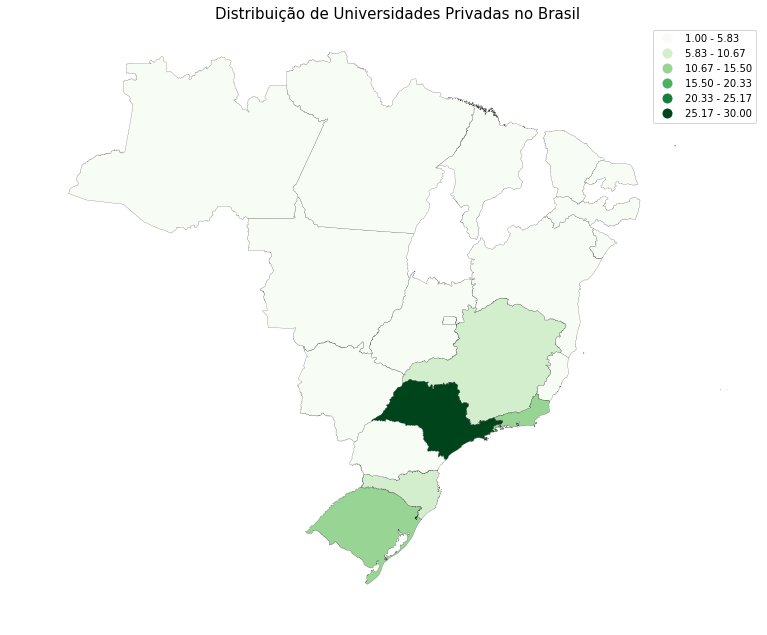

In [9]:
#Criando DF Universidades (Cod.1) Privadas (Cod. 4, 5 e 6) por Estado e cordenadas do mapa
priv = [4, 5, 6]
df_uni_priv_map = df_ies[['CO_IES', 'CO_UF']][(df_ies['TP_CATEGORIA_ADMINISTRATIVA'].isin(priv)) & 
                              (df_ies['TP_ORGANIZACAO_ACADEMICA']==1)].groupby('CO_UF').count().reset_index()
df_uni_priv_map.columns = ['CO_UF', 'QNT_PRIVADAS']

df_uni_priv_map = pd.merge(df_map[['CO_UF', 'geometry']], df_uni_priv_map, on='CO_UF', how='inner')


#Plotando novo DF com informação das coordenadas
ax = B.plot(column='QNT_PRIVADAS', 
                            cmap='Greens', 
                            figsize=(13, 13),
                            scheme='equal_interval',
                            linewidth=0.2, 
                            edgecolor='.2',
                            k=6,
                            legend=True)
ax.axis('off')
ax.set_title("Distribuição de Universidades Privadas no Brasil", 
             fontdict={'fontsize': '15', 'fontweight' : '10'}, 
             loc='center');

---

### Alunos por universidade

In [10]:
#Lendo tabela quantidade de alunos por entidades academicas
df_alunos_ies = pd.read_csv(r'data/aluno_x_faculdade.csv')
df_alunos_ies.head()

,CO_IES,QNT_ALUNOS
0,322,577780
1,298,553187
2,163,425218
3,671,297471
4,1491,255087


In [11]:
#Criando tabela somente com universidades
df_ies_alunos = df_ies[['CO_IES', 'NO_IES']][df_ies['TP_ORGANIZACAO_ACADEMICA']==1]
df_ies_alunos.head()

,CO_IES,NO_IES
0,1,UNIVERSIDADE FEDERAL DE MATO GROSSO
2,719,UNIVERSIDADE DO ESTADO DE MATO GROSSO
4,780,UNIVERSIDADE DE CUIABÁ
59,2,UNIVERSIDADE DE BRASÍLIA
62,403,UNIVERSIDADE CATÓLICA DE BRASÍLIA


In [12]:
#Criando Df com quantidade de alunos por universidade
df_ies_alunos = pd.merge(df_ies_alunos, df_alunos_ies, 
                         on='CO_IES', 
                         how='inner').sort_values('QNT_ALUNOS', 
                                                  ascending=False).reset_index()
df_ies_alunos.drop(['CO_IES', 'index'], axis=1, inplace=True)

In [13]:
#5 Universidade com maior numero de alunos
df_ies_alunos.head()

,NO_IES,QNT_ALUNOS
0,UNIVERSIDADE PAULISTA,577780
1,UNIVERSIDADE PITÁGORAS UNOPAR,553187
2,UNIVERSIDADE ESTÁCIO DE SÁ,425218
3,UNIVERSIDADE ANHANGUERA,297471
4,UNIVERSIDADE NOVE DE JULHO,218377


In [14]:
#5 Universidades com menor numero de alunos
df_ies_alunos.tail()

,NO_IES,QNT_ALUNOS
194,FUNDAÇÃO UNIVERSIDADE FEDERAL DE CIÊNCIAS DA S...,2661
195,UNIVERSIDADE ESTADUAL DE RORAIMA,2502
196,UNIVERSIDADE DO ESTADO DO AMAPÁ,2240
197,UNIVERSIDADE ESTADUAL DE CIÊNCIAS DA SAÚDE DE ...,1970
198,UNIVERSIDADE SANTA ÚRSULA,1433


---

## 2) Pergunta-se: é verdade que existe menos mulheres nos cursos de exatas? Explique com os dados.

In [15]:
#Abrindo dataset criado com sexo por cursos
df_sexo_curso = pd.read_csv(r'data/sexo_x_curso.csv')
df_sexo_curso

,CO_OCDE_AREA_GERAL,NO_AREA,MULHERES,HOMENS
0,1.0,Educação,1524668,683543
1,2.0,Humanidades e artes,137416,125739
2,3.0,"Ciências sociais, negócios e direito",2439780,1937184
3,4.0,"Ciências, matemática e computação",211812,477579
4,5.0,"Engenharia, produção e construção",536656,1154011
5,6.0,Agricultura e veterinária,148364,156163
6,7.0,Saúde e bem estar social,1271963,473202
7,8.0,Serviços,152080,103817


In [16]:
#Percentual de Homens e Mulheres nos cursos de exatas
ex_mulheres = (int(df_sexo_curso['MULHERES'][df_sexo_curso['CO_OCDE_AREA_GERAL']==4]) + 
int(df_sexo_curso['MULHERES'][df_sexo_curso['CO_OCDE_AREA_GERAL']==5]))

ex_homens = (int(df_sexo_curso['HOMENS'][df_sexo_curso['CO_OCDE_AREA_GERAL']==4]) + 
int(df_sexo_curso['HOMENS'][df_sexo_curso['CO_OCDE_AREA_GERAL']==5]))

ex_mulheres_per = round((ex_mulheres / (ex_mulheres + ex_homens) * 100), 2)
ex_homens_per = round((ex_homens / (ex_mulheres + ex_homens) * 100), 2)

df_percent_exatas = pd.DataFrame({'% No Curso de Exatas':{'Mulheres':ex_mulheres_per, 'Homens':ex_homens_per}})

df_percent_exatas

,% No Curso de Exatas
Homens,68.55
Mulheres,31.45


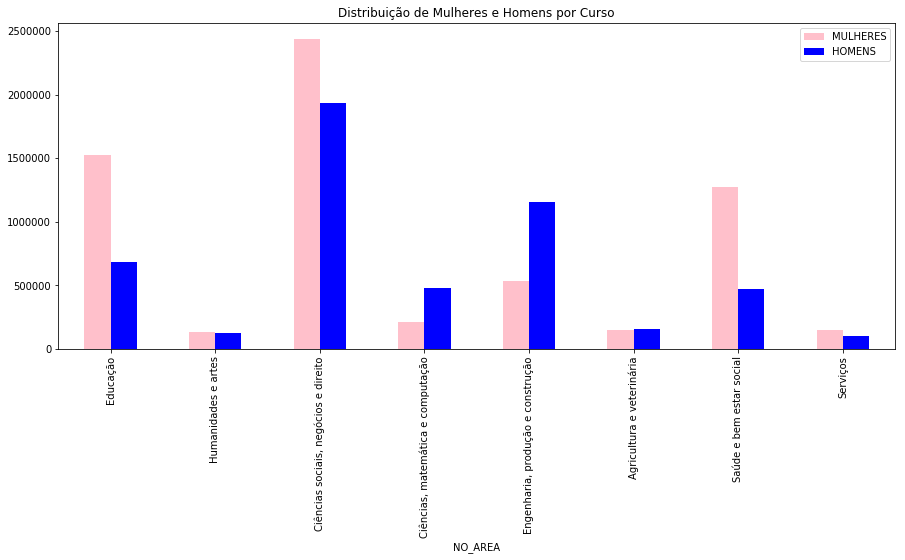

In [17]:
#Distribuição de Muheres e Homens por Curso
df_sexo_curso[['NO_AREA', 'MULHERES', 'HOMENS']].plot(kind='bar',
                                                      x='NO_AREA',
                                                      figsize=(15,6),
                                                      color=('Pink','Blue'),
                                                      fontsize=10,
                                                      title='Distribuição de Mulheres e Homens por Curso')
plt.show()

---

## 3) Quantos cursos novos abrem por ano?

In [18]:
#Abrindo DF Curso por ano

df_cursos = pd.read_csv(r'data/curso_x_ano.csv')

df_cursos = df_cursos[['ANO', 'QT_VAGA_TOTAL']][(df_cursos['ANO'] >= 2000) & 
                                                (df_cursos['ANO'] <= 2017)].groupby('ANO', as_index=False).count()

df_cursos.columns = ['ANO', 'NOVOS_CURSOS']

df_cursos

,ANO,NOVOS_CURSOS
0,2000.0,932
1,2001.0,1021
2,2002.0,1195
3,2003.0,1123
4,2004.0,1303
5,2005.0,1389
6,2006.0,1891
7,2007.0,1728
8,2008.0,1619
9,2009.0,2117


In [19]:
#Abertura média anual de Novos Cursos a partir de 2000
print(f"Em média abrem no Brasil {df_cursos.NOVOS_CURSOS.mean()} cursos por ano!")

Em média abrem no Brasil 1512.0 cursos por ano!


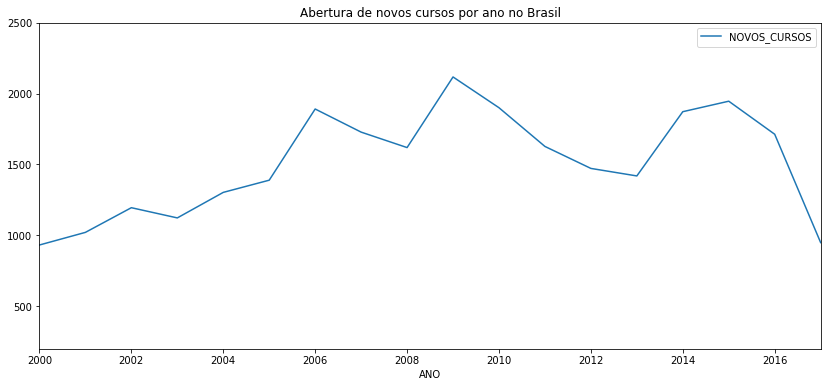

In [22]:
df_cursos.plot(kind='line',
               x='ANO',
               y='NOVOS_CURSOS',
               figsize=(14, 6),
               ylim=(200, 2500),
               title='Abertura de novos cursos por ano no Brasil')
plt.show()

---

## 4) Se usarmos a taxa de concluientes de um curso como variável de dificuldade dos cursos, eles tem ficado mais faceis ou mais duros ao longo do tempo? Quais as dificuldades para uma afirmação dessas?

In [25]:
#Lendo DF de cursos por quantidade de formados (considerados quem ingressou em 2013 sample de 10%)
df_info_cat = pd.read_csv(r'data/formados_x_curso.csv')
df_info_cat

,Agricultura e veterinária,"Ciências sociais, negócios e direito","Ciências, matemática e computação",Educação,"Engenharia, produção e construção",Humanidades e artes,Saúde e bem estar social,Serviços,SITUACAO
0,1899.0,15468.0,2330.0,6082.0,11418.0,800.0,7820.0,326.0,2
1,247.0,4119.0,714.0,1771.0,1835.0,321.0,1329.0,219.0,3
2,270.0,5592.0,1025.0,2307.0,2337.0,325.0,1648.0,284.0,4
3,5.0,166.0,41.0,55.0,128.0,18.0,49.0,6.0,5
4,935.0,13891.0,1406.0,5945.0,4428.0,479.0,5993.0,247.0,6
5,NaN,6.0,1.0,1.0,1.0,1.0,4.0,NaN,7


In [47]:
#Criando a taxa de formação por codigo geral de curso
tx_agri = round((df_info_cat['Agricultura e veterinária'][4] / df_info_cat['Agricultura e veterinária'].sum() * 100),2)
tx_dir = round((df_info_cat['Ciências sociais, negócios e direito'][4] / df_info_cat['Ciências sociais, negócios e direito'].sum() * 100),2)
tx_mat = round((df_info_cat['Ciências, matemática e computação'][4] / df_info_cat['Ciências, matemática e computação'].sum() * 100),2)
tx_educ = round((df_info_cat['Educação'][4] / df_info_cat['Educação'].sum() * 100),2)
tx_eng = round((df_info_cat['Engenharia, produção e construção'][4] / df_info_cat['Engenharia, produção e construção'].sum() * 100),2)
tx_art = round((df_info_cat['Humanidades e artes'][4] / df_info_cat['Humanidades e artes'].sum() * 100),2)
tx_saud = round((df_info_cat['Saúde e bem estar social'][4] / df_info_cat['Saúde e bem estar social'].sum() * 100),2)
tx_serv = round((df_info_cat['Serviços'][4] / df_info_cat['Serviços'].sum() * 100),2)


In [56]:
#Criando um DF com a formação por grupo de curso
df_formacao = pd.DataFrame({'% de Formação':{'Agricultura e veterinária':tx_agri, 
                                     'Ciências sociais, negócios e direito':tx_dir,
                                     'Ciências, matemática e computação':tx_mat,
                                     'Educação':tx_educ,
                                     'Engenharia, produção e construção':tx_eng,
                                     'Humanidades e artes':tx_art,
                                     'Saúde e bem estar social':tx_saud,
                                     'Serviços':tx_serv}})

df_formacao.sort_values('% de Formação', inplace=True)
df_formacao

,% de Formação
"Engenharia, produção e construção",21.98
Serviços,22.83
Humanidades e artes,24.64
"Ciências, matemática e computação",25.48
Agricultura e veterinária,27.86
"Ciências sociais, negócios e direito",35.40
Saúde e bem estar social,35.58
Educação,36.79


---

## 5) Rode uma regressão multipla que explique o abandono dos cursos, será que professores mais/menos preparados influência nessas taxas?

---

## 6) Quais os cursos com maior crescimento de matriculas por região? E quais os com maior queda? Como você explicaria isso.

In [11]:
#Lendo DF com a taxa da diferença de 2016 para 2017 (considerando cursos com mais de 5 alunos em cada ano)
df_matriculas = pd.read_csv(r'data/tx_x_regiao.csv')
df_matriculas.head()

,REGIAO,SG_IES,NO_CURSO,DT_INICIO_FUNCIONAMENTO,2016,2017,TAXA
0,CENTRO-OESTE,UFMT,DIREITO,05/09/1952,90.0,94.0,1.044
1,CENTRO-OESTE,UFMT,CIÊNCIAS ECONÔMICAS,11/10/1968,102.0,113.0,1.108
2,CENTRO-OESTE,UFMT,ENGENHARIA CIVIL,11/10/1968,56.0,55.0,0.982
3,CENTRO-OESTE,UFMT,PEDAGOGIA,15/09/1970,97.0,99.0,1.021
4,CENTRO-OESTE,UFMT,SERVIÇO SOCIAL,09/03/1970,78.0,81.0,1.038


### Região Norte

In [7]:
#Cinco cursos com maior aumento de matriculas da região Norte
df_matriculas[df_matriculas['REGIAO']=='NORTE'].sort_values('TAXA', ascending=False).head()

,REGIAO,SG_IES,NO_CURSO,DT_INICIO_FUNCIONAMENTO,2016,2017,TAXA
20019,NORTE,FIBRA,SERVIÇO SOCIAL,15/01/2015,7.0,133.0,19.000
19680,NORTE,UNAMA,NUTRIÇÃO,06/06/2016,9.0,152.0,16.889
2139,NORTE,ESBAM,CIÊNCIAS CONTÁBEIS,19/02/2001,7.0,117.0,16.714
2140,NORTE,ESBAM,ADMINISTRAÇÃO,30/03/2001,9.0,144.0,16.000
19683,NORTE,UNAMA,REDES DE COMPUTADORES,06/06/2016,11.0,133.0,12.091


In [68]:
#Cinco cursos com maior quede de matriculas da região Norte
df_matriculas[df_matriculas['REGIAO']=='NORTE'].sort_values('TAXA').head()

,REGIAO,SG_IES,NO_CURSO,DT_INICIO_FUNCIONAMENTO,2016,2017,TAXA
2027,NORTE,CIESA,ADMINISTRAÇÃO,02/05/1986,57.0,7.0,0.123
2271,NORTE,FBNCTSB,CIÊNCIAS TEOLÓGICAS,07/03/2005,269.0,33.0,0.123
2038,NORTE,UNINILTONLINS,EDUCAÇÃO FÍSICA,22/06/1999,186.0,23.0,0.124
2172,NORTE,FSDB,GESTÃO AMBIENTAL,03/03/2014,137.0,19.0,0.139
2173,NORTE,FSDB,GESTÃO FINANCEIRA,03/03/2014,126.0,18.0,0.143


### Região Nordeste

In [69]:
#Cinco cursos com maior aumento de matriculas da região Nordeste
df_matriculas[df_matriculas['REGIAO']=='NORDESTE'].sort_values('TAXA', ascending=False).head()

,REGIAO,SG_IES,NO_CURSO,DT_INICIO_FUNCIONAMENTO,2016,2017,TAXA
24523,NORDESTE,UNICEUMA,ENGENHARIA CIVIL,08/03/2013,7.0,158.0,22.571
2622,NORDESTE,IEST,DIREITO,01/10/2003,8.0,177.0,22.125
2623,NORDESTE,IEST,ENFERMAGEM,07/04/2008,6.0,121.0,20.167
17368,NORDESTE,UNEB,DIREITO,19/04/2006,7.0,107.0,15.286
17382,NORDESTE,UNEB,DIREITO,18/04/2012,7.0,104.0,14.857


In [70]:
#Cinco cursos com maior queda de matriculas da região Nordeste
df_matriculas[df_matriculas['REGIAO']=='NORDESTE'].sort_values('TAXA').head()

,REGIAO,SG_IES,NO_CURSO,DT_INICIO_FUNCIONAMENTO,2016,2017,TAXA
12951,NORDESTE,UFPE,ENGENHARIA CIVIL,03/06/1895,126.0,6.0,0.048
23045,NORDESTE,UEPB,JORNALISMO,12/10/1973,122.0,8.0,0.066
22415,NORDESTE,NaN,DIREITO,04/06/2001,163.0,11.0,0.067
24718,NORDESTE,NaN,ENGENHARIA MECÂNICA,07/02/2011,139.0,10.0,0.072
22424,NORDESTE,IFRN,GEOGRAFIA,04/09/2002,63.0,6.0,0.095


### Centro-Oeste

In [9]:
#Cinco cursos com maior aumento de matriculas da região Centro-Oeste
df_matriculas[df_matriculas['REGIAO']=='CENTRO-OESTE'].sort_values('TAXA', ascending=False).head()

,REGIAO,SG_IES,NO_CURSO,DT_INICIO_FUNCIONAMENTO,2016,2017,TAXA
23773,CENTRO-OESTE,UEMS,DIREITO,08/08/1997,7.0,207.0,29.571
903,CENTRO-OESTE,UNIP,REDES DE COMPUTADORES,14/02/2006,6.0,107.0,17.833
23852,CENTRO-OESTE,FCG,FISIOTERAPIA,18/02/2003,8.0,123.0,15.375
23753,CENTRO-OESTE,NaN,PEDAGOGIA,07/10/1994,6.0,89.0,14.833
1630,CENTRO-OESTE,JK BSB RE,CIÊNCIAS CONTÁBEIS,01/08/2007,11.0,121.0,11.000


In [72]:
#Cinco cursos com maior queda de matriculas da região Centro-Oeste
df_matriculas[df_matriculas['REGIAO']=='CENTRO-OESTE'].sort_values('TAXA').head()

,REGIAO,SG_IES,NO_CURSO,DT_INICIO_FUNCIONAMENTO,2016,2017,TAXA
708,CENTRO-OESTE,UPIS,DIREITO,02/08/1999,187.0,8.0,0.043
21866,CENTRO-OESTE,IESGO,PEDAGOGIA,12/02/2007,92.0,6.0,0.065
722,CENTRO-OESTE,UDF,CIÊNCIAS BIOLÓGICAS,07/02/2011,78.0,6.0,0.077
707,CENTRO-OESTE,UPIS,CIÊNCIAS CONTÁBEIS,17/02/1987,84.0,7.0,0.083
709,CENTRO-OESTE,UPIS,AGRONOMIA,14/02/2000,119.0,10.0,0.084


### Sudeste

In [73]:
#Cinco cursos com maior aumento de matriculas da região Sudeste
df_matriculas[df_matriculas['REGIAO']=='SUDESTE'].sort_values('TAXA', ascending=False).head()

,REGIAO,SG_IES,NO_CURSO,DT_INICIO_FUNCIONAMENTO,2016,2017,TAXA
16847,SUDESTE,NaN,FISIOTERAPIA,14/03/2011,6.0,216.0,36.000
1133,SUDESTE,UNIP,MARKETING,10/03/2003,6.0,153.0,25.500
10137,SUDESTE,NaN,ENGENHARIA ELETRÔNICA,09/03/2009,8.0,191.0,23.875
1131,SUDESTE,UNIP,COMÉRCIO EXTERIOR,10/03/2003,8.0,135.0,16.875
7422,SUDESTE,FMU,DESIGN,14/02/2000,6.0,97.0,16.167


In [74]:
#Cinco cursos com maior queda de matriculas da região Sudeste
df_matriculas[df_matriculas['REGIAO']=='SUDESTE'].sort_values('TAXA').head()

,REGIAO,SG_IES,NO_CURSO,DT_INICIO_FUNCIONAMENTO,2016,2017,TAXA
6755,SUDESTE,UNICSUL,ARTES VISUAIS,16/02/2004,128.0,6.0,0.047
16268,SUDESTE,UNIGRANRIO,GESTÃO DE RECURSOS HUMANOS,02/02/2004,123.0,6.0,0.049
9443,SUDESTE,NaN,ADMINISTRAÇÃO,05/02/2001,150.0,8.0,0.053
9448,SUDESTE,NaN,CIÊNCIAS CONTÁBEIS,13/02/2006,184.0,10.0,0.054
7047,SUDESTE,ETEP,ENGENHARIA ELÉTRICA,26/01/2005,88.0,6.0,0.068


### Região Sul

In [75]:
#Cinco cursos com maior aumento de matriculas da região Sul
df_matriculas[df_matriculas['REGIAO']=='SUL'].sort_values('TAXA', ascending=False).head()

,REGIAO,SG_IES,NO_CURSO,DT_INICIO_FUNCIONAMENTO,2016,2017,TAXA
15140,SUL,FADERGS,ESTÉTICA E COSMÉTICA,NaN,14.0,504.0,36.000
12569,SUL,FCV,PSICOLOGIA,20/06/2016,9.0,113.0,12.556
21085,SUL,AVANTIS,ENGENHARIA ELÉTRICA,01/08/2016,7.0,71.0,10.143
12471,SUL,IESFI,EDUCAÇÃO FÍSICA,03/06/2013,6.0,60.0,10.000
14008,SUL,UNISC,COMPUTAÇÃO,05/08/1999,6.0,58.0,9.667


In [76]:
#Cinco cursos com maior queda de matriculas da região Sul
df_matriculas[df_matriculas['REGIAO']=='SUL'].sort_values('TAXA').head()

,REGIAO,SG_IES,NO_CURSO,DT_INICIO_FUNCIONAMENTO,2016,2017,TAXA
11783,SUL,UP,COMÉRCIO EXTERIOR,23/02/2015,61.0,10.0,0.164
15141,SUL,FADERGS,ESTÉTICA E COSMÉTICA,08/08/2016,126.0,21.0,0.167
21242,SUL,FVA,EDUCAÇÃO FÍSICA,02/06/2011,54.0,9.0,0.167
12147,SUL,NaN,SERVIÇO SOCIAL,09/02/2009,35.0,6.0,0.171
15382,SUL,FTSG,GESTÃO COMERCIAL,02/07/2014,58.0,10.0,0.172


---

## 7) Construa uma variável "Signo" dos estudantes e explique porque ela é correlacionada com a variável "probabilidade de formação" (construir)